In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18, 5)

from plotting import smooth
from student_env import StudentEnv  # The student simulator env
from agents import RandomAgent, WeakestSkillAgent, MultiArmBanditEpsilonGreedy, MultiArmBanditEpsilonSampleProb

from stable_baselines.common.vec_env.vec_normalize import VecNormalize
from stable_baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines.common.cmd_util import arg_parser
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import set_global_seeds
from stable_baselines import bench, logger

from stable_baselines.ppo2 import PPO2

/Users/kirillpolzunov/Applications/miniconda3/envs/qube/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kirillpolzunov/Applications/miniconda3/envs/qube/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kirillpolzunov/Applications/miniconda3/envs/qube/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16"

# Helper functions

In [47]:
def run_agent(env, agent, train_eps=1000, test_eps=100, print_episodes=50):
    train_rewards = np.zeros((train_eps, env.envs[0].max_steps))
    test_rewards = np.zeros((test_eps, env.envs[0].max_steps))
    obs = np.zeros((env.num_envs,) + env.observation_space.shape)

    for episode in range(train_eps):
        obs[:] = env.reset()
        action = [0] # Just need a first action to do something
        done = False

        if episode % print_episodes == 0:
            print(f"Epsiode {episode}")

        while not done:
            obs[:], reward, done, info = env.step(action)
            train_rewards[episode, env.envs[0].i-1] = reward
            action = agent(obs, reward, done, info)

    for episode in range(test_eps):
        obs[:] = env.reset()
        action = [0] # Just need a first action to do something
        done = False

        if episode % print_episodes == 0:
            print(f"Epsiode {episode}")

        while not done:
            obs[:], reward, done, info = env.step(action)
            test_rewards[episode,env.envs[0].i-1] = reward
            action = agent(obs, reward, done, info)

    return agent, train_rewards, test_rewards

In [3]:
def plot_agent_run(rewards, title=None, w=500):
    # Get avg rewards
    avg_rewards = np.sum(rewards, axis=1)
    over_avg_reward = np.mean(avg_rewards)
    
    sns.regplot(np.arange(avg_rewards.shape[0]), avg_rewards, marker=".")
    if title:
        plt.title(title)
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.show()
    
    
#     # Smooth data
#     avg_rewards = smooth(avg_rewards, window_len=w) # window size w
    
#     # Plot
#     plt.plot(avg_rewards)
#     if title:
#         plt.title(title)
#     plt.xlabel("Episodes")
#     plt.ylabel(f"Reward (smooth = {w})")
#     plt.show()
    
    

In [4]:
def plot_episode_reward(rewards, title=None, episode=0):    
    sns.regplot(np.arange(rewards.shape[0]), rewards, marker=".", logistic=True)
    if title:
        plt.title(title)
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.show()


In [5]:
# Use the same environment spec (ie same students) for all agents to make comparing more fair
def make_env():
    env_out = StudentEnv()
    env_out = bench.Monitor(env_out, logger.get_dir(), allow_early_resets=True)
    return env_out
env = DummyVecEnv([make_env])

train_eps = 100
test_eps = 100

# Random Agent

In [6]:
env.reset()
rand_agent = RandomAgent(env.envs[0].n_concepts)
rand_agent, rand_train_rewards, rand_test_rewards = run_agent(env, rand_agent, train_eps=0, test_eps=test_eps)

Epsiode 0


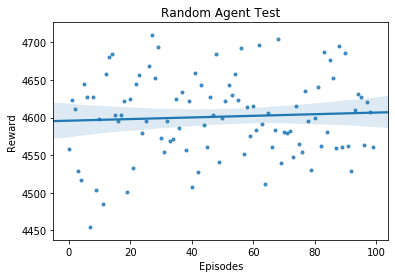

[-5.2017801  -7.36320617 -8.36096319 -7.24201132 -7.12943233]
[-5.2017801  -7.36320617 -8.36096319 -7.24201132 -7.12943233]


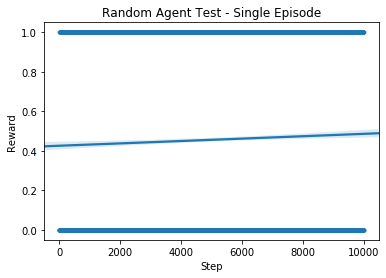

In [7]:
plot_agent_run(rand_test_rewards, "Random Agent Test")
print(env.envs[0].students_init[0].skills)
print(env.envs[0].students[0].skills)
plot_episode_reward(rand_test_rewards[0], "Random Agent Test - Single Episode")

# Weakest Skill Agent

In [8]:
env.reset()
ws_agent = WeakestSkillAgent(env.envs[0].n_concepts)
ws_agent, ws_train_rewards, ws_test_rewards = run_agent(env, ws_agent, train_eps=0, test_eps=test_eps)

Epsiode 0


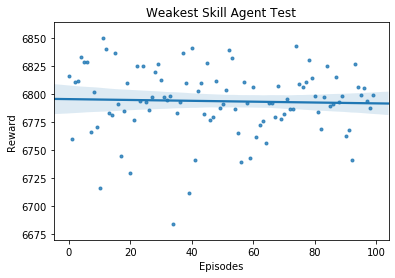

[-5.2017801  -7.36320617 -8.36096319 -7.24201132 -7.12943233]
[-5.2017801  -7.36320617 -8.36096319 -7.24201132 -7.12943233]


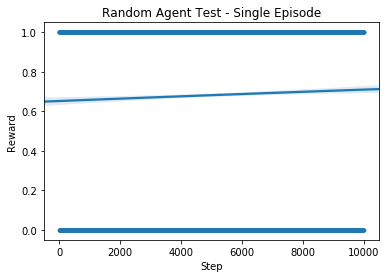

In [9]:
plot_agent_run(ws_test_rewards, "Weakest Skill Agent Test")
print(env.envs[0].students_init[0].skills)
print(env.envs[0].students[0].skills)


plot_episode_reward(ws_test_rewards[0], "Random Agent Test - Single Episode")

# Multi Arm Bandit Epsilon Greedy Agent

In [10]:
env.reset()
eg_agent = MultiArmBanditEpsilonGreedy(env.envs[0].n_concepts)
eg_agent, eg_train_rewards, eg_test_rewards = run_agent(env, eg_agent, train_eps=train_eps, test_eps=test_eps)

Epsiode 0
Epsiode 0


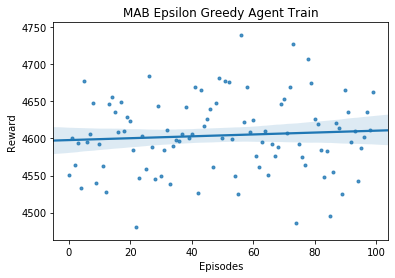

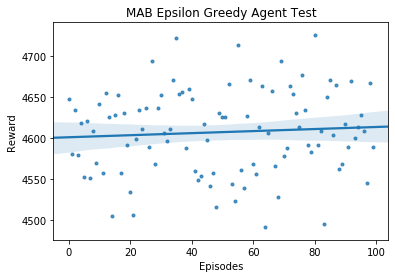

[-5.2017801  -7.36320617 -8.36096319 -7.24201132 -7.12943233]
[-5.2017801  -7.36320617 -8.36096319 -7.24201132 -7.12943233]


In [11]:
plot_agent_run(eg_train_rewards, "MAB Epsilon Greedy Agent Train")
plot_agent_run(eg_test_rewards, "MAB Epsilon Greedy Agent Test")
print(env.envs[0].students_init[0].skills)
print(env.envs[0].students[0].skills)

# Multi Arm Bandit Sample Q function Agent

In [12]:
# env.reset()
# sp_agent = MultiArmBanditEpsilonSampleProb(env.envs[0].n_concepts)
# sp_agent, sp_train_rewards, sp_test_rewards = run_agent(env, sp_agent, train_eps=train_eps, test_eps=test_eps)

In [13]:
# plot_agent_run(sp_train_rewards, "MAB Sample Q function Agent Train")
# plot_agent_run(sp_test_rewards, "MAB Sample Q function Agent Test")
# print(env.envs[0].students_init[0].skills)
# print(env.envs[0].students[0].skills)

# Additional info

In [14]:
sorted([e for e in env.envs[0].questions[:40]], key=lambda x: x.concepts)

[Question(concepts=(0,), difficulty=11.119684935376437),
 Question(concepts=(0,), difficulty=9.348439770194952),
 Question(concepts=(0,), difficulty=11.19037390532373),
 Question(concepts=(0,), difficulty=9.574630959264534),
 Question(concepts=(0,), difficulty=9.316551315776325),
 Question(concepts=(0,), difficulty=10.971569568762273),
 Question(concepts=(0,), difficulty=9.57449639660282),
 Question(concepts=(0,), difficulty=8.649146727812754),
 Question(concepts=(0,), difficulty=10.141722359614802),
 Question(concepts=(1,), difficulty=2.6467052418805768),
 Question(concepts=(1,), difficulty=3.707215341665331),
 Question(concepts=(1,), difficulty=2.563347926279077),
 Question(concepts=(1,), difficulty=1.446365756973853),
 Question(concepts=(1,), difficulty=2.534498537296761),
 Question(concepts=(1,), difficulty=2.8617498255354183),
 Question(concepts=(1,), difficulty=3.45211334534758),
 Question(concepts=(1,), difficulty=4.073286167750313),
 Question(concepts=(2,), difficulty=-1.196753

In [15]:
# Columns are learning styles
# Rows are concepts
eg_agent.q.reshape(eg_agent.n_concepts, eg_agent.n_learning_styles)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [17]:
np.sum(ws_test_rewards)/100, np.sum(rand_test_rewards)/100, np.sum(eg_test_rewards)/100

(6793.63, 4601.16, 4607.17)

In [ ]:
# [(env.questions[i % env.envs[0].n_questions], r1, r2) for i, (r1, r2) in enumerate(zip(rand_test_rewards[1], rand_test_rewards[-1]))]

In [ ]:
# [(env.questions[i % env.envs[0].n_questions], r1, r2) for i, (r1, r2) in enumerate(zip(ws_test_rewards[1], ws_test_rewards[-1]))]

In [59]:
policy = MlpPolicy
ppo_model = PPO2(policy=policy, env=env)
ppo_model.load_parameters("/Users/kirillpolzunov/code/research/bt/logs/1e7/seed-601/model.zip")

ppo_agent = lambda obs, reward, done, info: ppo_model.step(obs)[0]

In [63]:
env.reset()
ppo_agent, ppo_train_rewards, ppo_test_rewards = run_agent(env, ppo_agent, train_eps=0, test_eps=test_eps, print_episodes=1)

Epsiode 0
Epsiode 1
Epsiode 2
Epsiode 3
Epsiode 4
Epsiode 5
Epsiode 6
Epsiode 7
Epsiode 8
Epsiode 9
Epsiode 10
Epsiode 11
Epsiode 12
Epsiode 13
Epsiode 14
Epsiode 15
Epsiode 16
Epsiode 17
Epsiode 18
Epsiode 19
Epsiode 20
Epsiode 21
Epsiode 22
Epsiode 23
Epsiode 24
Epsiode 25
Epsiode 26
Epsiode 27
Epsiode 28
Epsiode 29
Epsiode 30
Epsiode 31
Epsiode 32
Epsiode 33
Epsiode 34
Epsiode 35
Epsiode 36
Epsiode 37
Epsiode 38
Epsiode 39
Epsiode 40
Epsiode 41
Epsiode 42
Epsiode 43
Epsiode 44
Epsiode 45
Epsiode 46
Epsiode 47
Epsiode 48
Epsiode 49
Epsiode 50
Epsiode 51
Epsiode 52
Epsiode 53
Epsiode 54
Epsiode 55
Epsiode 56
Epsiode 57
Epsiode 58
Epsiode 59
Epsiode 60
Epsiode 61
Epsiode 62
Epsiode 63
Epsiode 64
Epsiode 65
Epsiode 66
Epsiode 67
Epsiode 68
Epsiode 69
Epsiode 70
Epsiode 71
Epsiode 72
Epsiode 73
Epsiode 74
Epsiode 75
Epsiode 76
Epsiode 77
Epsiode 78
Epsiode 79
Epsiode 80
Epsiode 81
Epsiode 82
Epsiode 83
Epsiode 84
Epsiode 85
Epsiode 86
Epsiode 87
Epsiode 88
Epsiode 89
Epsiode 90
Epsiode 9

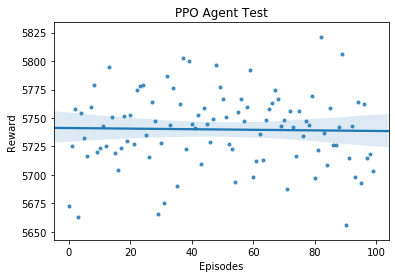

[-5.2017801  -7.36320617 -8.36096319 -7.24201132 -7.12943233]
[-5.2017801  -7.36320617 -8.36096319 -7.24201132 -7.12943233]


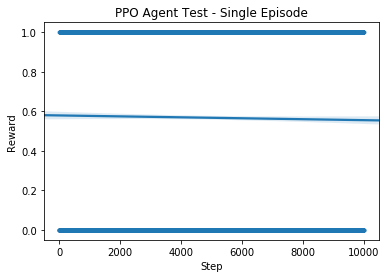

In [64]:
plot_agent_run(ppo_test_rewards, "PPO Agent Test")
print(env.envs[0].students_init[0].skills)
print(env.envs[0].students[0].skills)

plot_episode_reward(ppo_test_rewards[0], "PPO Agent Test - Single Episode")

In [79]:
[ppo_agent([[0,x]], 0,0,0) for x in range(100)]

[array([12]),
 array([8]),
 array([12]),
 array([12]),
 array([8]),
 array([12]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([12]),
 array([8]),
 array([12]),
 array([12]),
 array([12]),
 array([12]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([12]),
 array([4]),
 array([8]),
 array([12]),
 array([12]),
 array([8]),
 array([12]),
 array([12]),
 array([4]),
 array([12]),
 array([12]),
 array([8]),
 array([12]),
 array([8]),
 array([8]),
 array([12]),
 array([8]),
 array([8]),
 array([12]),
 array([8]),
 array([12]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([4]),
 array([8]),
 array([12]),
 array([12]),
 array([8]),
 array([8]),
 array([6]),
 array([12]),
 array([12]),
 array([12]),
 array([8]),
 array([12]),
 array([12]),
 array([8]),
 array([8]),
 array([8]),
 array([12]),
 array([8]),
 array([12]),
 array([12]),
 array([12]),
 array([12]),
 array([12]),
 array([8]),
 array([8]),
 array([4]),
 array([12]),
 array([11]),
 array([12]),
 a